## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Wine dataset with response in {0, 1, 2}, 13 features and 178 samples
X, y = load_wine(return_X_y=True)

In [3]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [4]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_ones, y, test_size=0.3, random_state=42)

## Case 1: Analytical attack - Max disruption

In [15]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [16]:
def kl_div(mu_n, lam_n, sigma2, x, x_adv):
    sigma2_A = x_adv.T @ torch.inverse(lam_n) @ x_adv + sigma2
    mu_A = x_adv.T @ mu_n
    sigma2_D = x.T @ torch.inverse(lam_n) @ x + sigma2
    mu_D = x.T @ mu_n
    kl = 0.5 * (torch.log(sigma2_D / sigma2_A) + (sigma2_A + (mu_A - mu_D)**2) / sigma2_D - 1)
    return kl

In [17]:
# kl minimization to find adversarial attacked to a trained model
def kl_minimization(model, x, lr=0.01, n_iter=100, epsilon=.3):
    x_adv_values = []
    kl_values = []
    
    mu_n = model.mu
    lam_n = model.lam
    sigma2 = model.sigma2
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
        kl.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        kl_values.append(kl.detach().item())

    return x_adv.detach().numpy(), x_adv_values, kl_values 

In [18]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
x_adv_distr, x_adv_values, kl_values = kl_minimization(model, x, epsilon=0.3)

In [19]:
print(x_adv_distr, '\n', X_test[17,:])

[ 1.0847095   0.07063415 -0.05446609  0.11699987  0.08841725  0.01417863
  0.17283657  0.18965709  0.00241541  0.5659677   0.34585792  0.37810102] 
 [1.         0.16346154 0.03921569 0.19879518 0.00613497 0.08605341
 0.07317073 0.28306265 0.08733372 0.48181818 0.26744186 0.29032258]


Text(0, 0.5, 'KL Divergence')

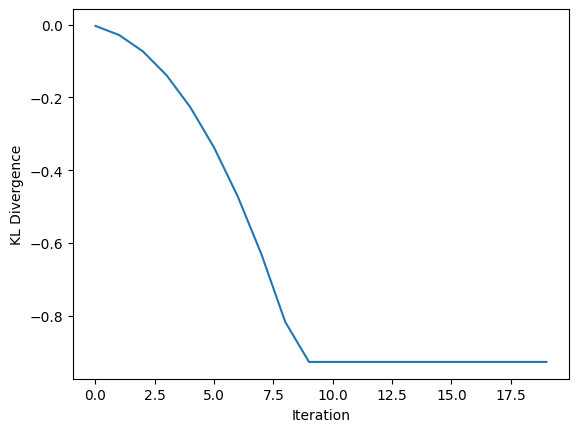

In [20]:
plt.plot(kl_values[:20])
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

Text(0.5, 0, 'y')

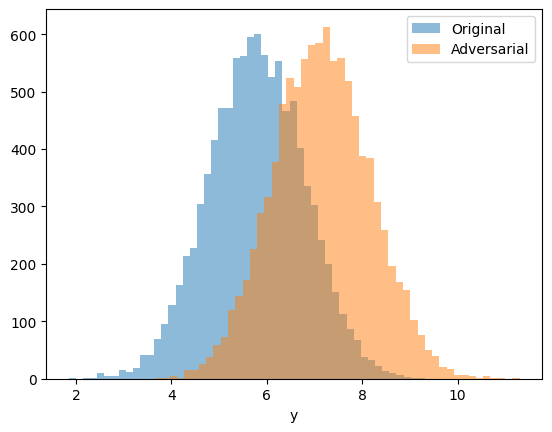

In [21]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

Text(0, 0.5, 'KL Divergence')

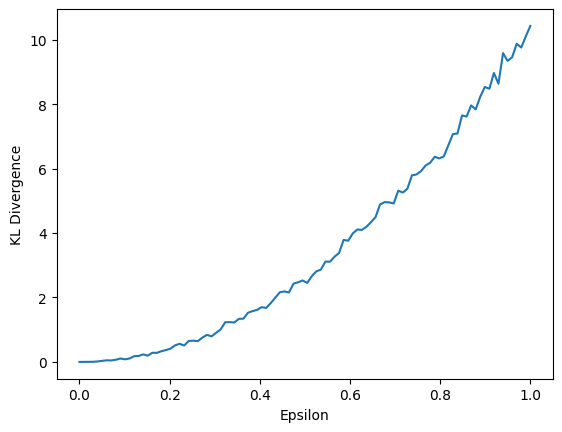

In [23]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)

# plot KL divergence as a function of the strength of the attack
epsilons = np.linspace(0, 1, 100)
kl_values = []
for epsilon in epsilons:
    x_adv_distr, _, kl = kl_minimization(model, x, epsilon=epsilon)
    kl_values.append(-kl[-1])

plt.plot(epsilons, kl_values)
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

Text(0, 0.5, 'KL Divergence')

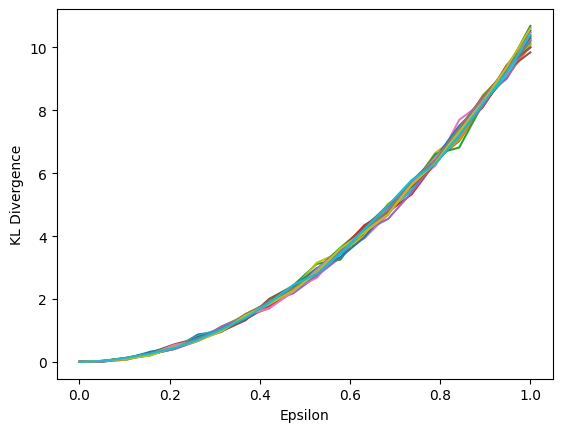

In [27]:
for i in range(20):
    x = X_test[i,:].copy()
    x = torch.tensor(x, dtype=torch.float32)
    
    kl_values = []
    for epsilon in np.linspace(0, 1, 20):
        x_adv_distr, _, kl = kl_minimization(model, x, epsilon=epsilon)
        kl_values.append(-kl[-1])
    
    plt.plot(np.linspace(0, 1, 20), kl_values, label=f'Example {i}')

# plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

## Case 2: SGD attack

In [29]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [30]:
# Function pi(y | x', gamma)
def pi(y, x, gamma):
    return torch.distributions.normal.Normal(x @ gamma[0], gamma[1]).log_prob(y).exp()

# Gradient of pi(y | x', gamma) with respect to x'
# pi(y | x', gamma) is Normal(x' @ beta, sigma2) with beta = gamma[0] and sigma2 = gamma[1]
def grad_pi(y, x, gamma):
    distr = torch.distributions.normal.Normal(x @ gamma[0], gamma[1])
    prob = distr.log_prob(y).exp()
    grad = - (x @ gamma[0] - y) / gamma[1] * prob * gamma[0]
    return grad


In [31]:
# g_{x', M}(y)
def g_x_prime_M(y, x_prime, gamma_samples):
    M = gamma_samples[0].shape[1]
    betas = gamma_samples[0]
    sigmas = gamma_samples[1]
    numerator = sum(grad_pi(y, x_prime, [betas[:, m], sigmas[:, m]]) for m in range(M)) / M
    denominator = sum(pi(y, x_prime, [betas[:, m], sigmas[:, m]]) for m in range(M)) / M
    return -numerator / denominator

In [59]:
# Define sequence M_l
M_sequence = [2**l for l in range(10)] # TODO TODO TODO

In [60]:
# Compute Δg_{x', l}(y)
def delta_g_x_prime_l(y, x_prime, l, model):
    M_l = M_sequence[l]
    M_l_minus_1 = M_sequence[l-1] if l > 0 else 0
    gamma_samples_l = model.sample_posterior_distribution(M_l)
    gamma_samples_l_minus_1 = model.sample_posterior_distribution(M_l_minus_1) if l > 0 else None

    g_l = g_x_prime_M(y, x_prime, gamma_samples_l)
    g_l_minus_1 = g_x_prime_M(y, x_prime, gamma_samples_l_minus_1) if l > 0 else 0

    return g_l - g_l_minus_1

In [61]:
# Define weights ω_l
tau = 1.0  # Example tau value
omega = [2**(-tau * l) for l in range(len(M_sequence))]
omega = np.array(omega)
omega /= omega.sum()  # Normalize

# Estimate the gradient using MLMC
def mlmc_gradient_estimator(y, x_prime, R, model):
    l_indices = np.random.choice(len(M_sequence), size=R, p=omega)
    estimates = []

    for l in l_indices:
        delta_g = delta_g_x_prime_l(y, x_prime, l, model)
        estimates.append(delta_g / omega[l])
        
    return sum(estimates) / R

# Example usage
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y_test[17], dtype=torch.float32)
R = 100

gradient_estimate = mlmc_gradient_estimator(y, x, R, model)
print(gradient_estimate)

tensor([ 6.6015, -0.1434, -2.5119, -0.0636,  3.0743, -0.2316,  2.0780, -0.2999,
        -2.0843,  0.4990,  0.6088,  2.7237])


In [62]:
# Attack function to use the gradient estimator for maximum disruption
def mlmc_attack(model, x, lr=0.01, n_iter=100, epsilon=.1, R=100):
    x_adv_values = []
    
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)

    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        y = model.sample_predictive_distribution(x_adv, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, R, model)
        x_adv.grad = gradient_estimate.squeeze()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())

    return x_adv.detach().numpy(), x_adv_values

In [12]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=0.3, R=100)

In [13]:
print(x_adv_distr, '\n', X_test[17,:])

[0.98830396 0.15171248 0.038996   0.23059568 0.00247798 0.14350781
 0.02971262 0.2975739  0.11733789 0.44316837 0.23736084 0.28915966] 
 [1.         0.16346154 0.03921569 0.19879518 0.00613497 0.08605341
 0.07317073 0.28306265 0.08733372 0.48181818 0.26744186 0.29032258]


Text(0.5, 0, 'y')

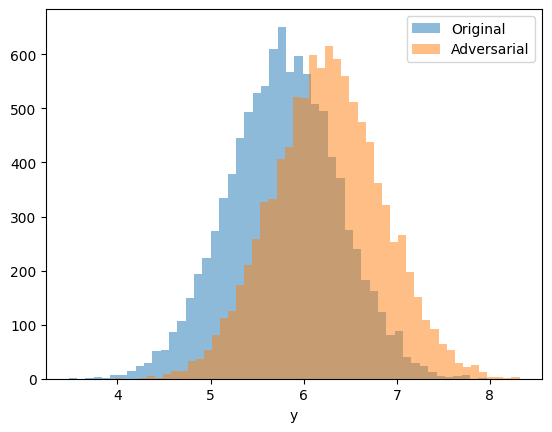

In [27]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

Text(0.5, 0, 'y')

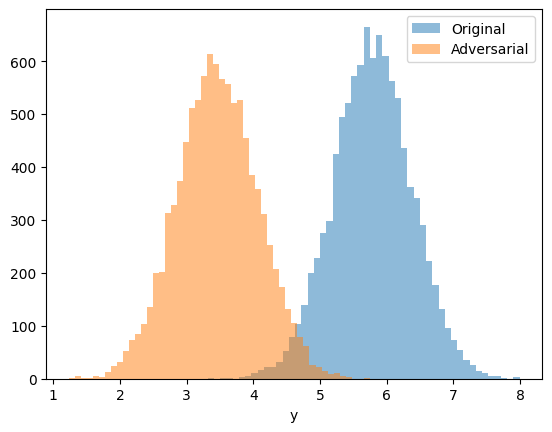

In [66]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=.5, R=100)
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Text(0, 0.5, 'KL Divergence')

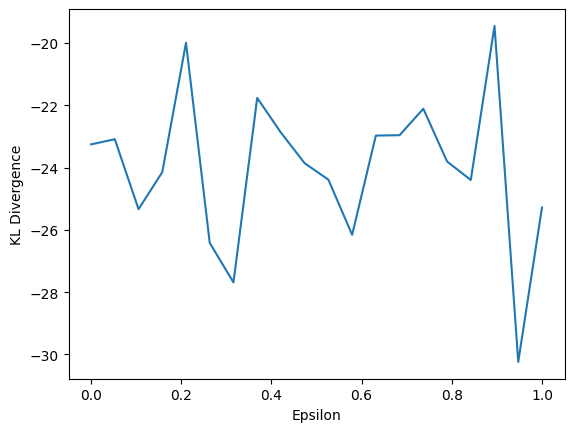

In [38]:
# TODO: esto esta bien? pocas muestras?
# # plot KL divergence as a function of the strength of the attack
epsilons = np.linspace(0, 1, 20)
kl_values = []
for epsilon in epsilons:
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    val = torch.nn.KLDivLoss()(
        model.sample_predictive_distribution(x, num_samples=10000), 
        model.sample_predictive_distribution(torch.tensor(x_adv_distr, dtype=torch.float32), num_samples=10000)
        )
    kl_values.append(val)

plt.plot(epsilons, kl_values)
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905991019/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  mean = X_test.T @ self.mu
/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.

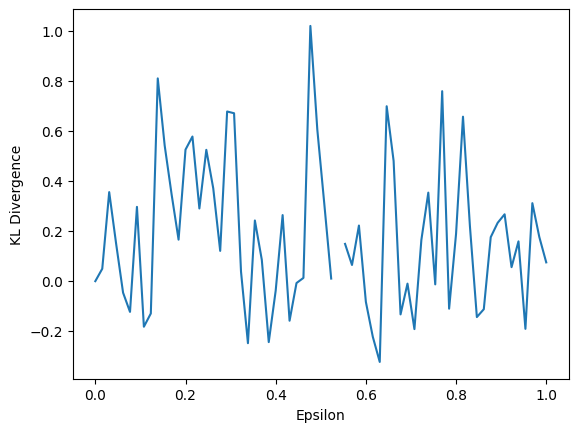

In [44]:
from joblib import Parallel, delayed
import numpy as np
import torch
import matplotlib.pyplot as plt

n_jobs = 66

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    x_samples = model.sample_predictive_distribution(x, num_samples=100000)
    x_adv_samples = model.sample_predictive_distribution(torch.tensor(x_adv_distr, dtype=torch.float32), num_samples=100000)
    hist_x, _ = np.histogram(x_samples, bins=20, density=True)
    hist_x_adv, _ = np.histogram(x_adv_samples, bins=20, density=True)
    val = (hist_x * np.log(hist_x / hist_x_adv)).sum()
    return val

# Define the range of epsilon values
epsilons = np.linspace(0, 1, 22)

# Use joblib to parallelize the computation of KL divergences
kl_values = Parallel(n_jobs=n_jobs)(
    delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons
)

# Plotting the results
plt.plot(epsilons, kl_values)
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')
plt.show()

### Case 2b: Same model as case 1

In [18]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [19]:
# g_{x', M}(y)
def g_x_prime_M(y, x_prime, gamma_samples):
    M = gamma_samples[0].shape[1]
    betas = gamma_samples[0]
    sigmas = gamma_samples[1]
    numerator = sum(grad_pi(y, x_prime, [betas[:, m], sigmas]) for m in range(M)) / M
    denominator = sum(pi(y, x_prime, [betas[:, m], sigmas]) for m in range(M)) / M
    return -numerator / denominator

In [20]:
# Define weights ω_l
tau = 1.0  # Example tau value
omega = [2**(-tau * l) for l in range(len(M_sequence))]
omega = np.array(omega)
omega /= omega.sum()  # Normalize

# Estimate the gradient using MLMC
def mlmc_gradient_estimator(y, x_prime, R, model):
    l_indices = np.random.choice(len(M_sequence), size=R, p=omega)
    estimates = []

    for l in l_indices:
        delta_g = delta_g_x_prime_l(y, x_prime, l, model)
        estimates.append(delta_g / omega[l])
        
    return sum(estimates) / R

# Example usage
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y_test[17], dtype=torch.float32)
R = 100

gradient_estimate = mlmc_gradient_estimator(y, x, R, model)
print(gradient_estimate)

tensor([ 4.2252, -0.1054, -1.7644, -0.1401,  2.1439,  0.0093,  0.7316,  0.1149,
        -2.3142,  0.2268,  0.4808,  1.5122])


In [21]:
# Attack function to use the gradient estimator for maximum disruption
def mlmc_attack(model, x, lr=0.01, n_iter=100, epsilon=.1, R=100):
    x_adv_values = []
    
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)

    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        y = model.sample_predictive_distribution(x_adv, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, R, model)
        x_adv.grad = gradient_estimate.squeeze()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())

    return x_adv.detach().numpy(), x_adv_values

In [23]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=0.3)

Text(0.5, 0, 'y')

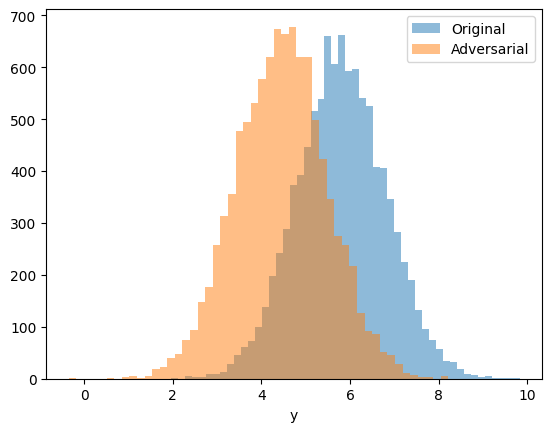

In [24]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')